In [ ]:
# thư viện cần tải
!pip install ta



In [1]:
# import thư viện
import os
from ta.trend import ADXIndicator
from ta.momentum import ROCIndicator
import time
import numpy as np
import pandas as pd
import joblib

import xgboost as xgb
from vnstock import Vnstock
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Thư viện vẽ biểu đồ
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from statsmodels.tsa.seasonal import STL

In [ ]:
# Biến cố định
dictionary = "data_vnstock/"

In [ ]:
# khai báo object lấy từ nguồn TCBS/VCI
stockVN = Vnstock().stock(symbol='ACB', source='VCI')

# lấy ra danh sách các cổ phiếu
all_tickers = stockVN.listing.all_symbols()['symbol'].tolist()
print("Tổng số mã: {:d}".format(len(all_tickers)))

In [ ]:
# tạo file
os.makedirs("data_vnstock", exist_ok=True)

# Tải dữ liệu cổ phiếu và lưu CSV với delay giữa các request (10 request nghỉ 100s)
for ticker in all_tickers:
    try:
        stock = Vnstock().stock(symbol=ticker, source='VCI')
        df = stock.quote.history(start='2015-06-26', end='2025-06-26')
        if not df.empty:
            df.to_csv(f"data_vnstock/{ticker}.csv", index=False)
            print(f"Lưu thành công: {ticker}")
        request_count += 1
        if request_count % 10 == 0:
            print("\n⏳ Nghỉ 100 giây sau 10 request...")
            time.sleep(100)
        else:
            time.sleep(1)
    except Exception as e:
        print(f"Lỗi với {ticker}: {e}")



In [ ]:
# test thử data 1 mã (Không thuộc luồng)
name = "LDG"

df = pd.read_csv(os.path.join(dictionary, name + '.csv'), sep=',')

df['time'] = pd.to_datetime(df['time'])
df.index = range(len(df))

print(df.tail())

for i in range(len(all_tickers)):
    if (name == all_tickers[i]):
        print(i)
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('time', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()


In [ ]:
# dùng để tính rsi
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [ ]:
# dùng để lọc những data có khối lượng giao dịch thấp, hạn chế giao dịch và dữ liệu kém
def filter_data(df):
    obtain = True
    if len(df) < 100:
        obtain = False
    
    last_date = df['time'].max()
    if (pd.Timestamp.today() - last_date).days > 90:
        obtain = False

    recent_dates = df['time'].dt.date.unique()
    recent_30d = pd.Timestamp.today().date() - pd.to_timedelta(30, unit='d')
    active_days_last_30 = [d for d in recent_dates if d >= recent_30d]
    if len(active_days_last_30) < 10:
        obtain = False

    if df['volume'].tail(20).mean() < 100000:
        obtain = False

    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 15:
        obtain = False
        
    return obtain

In [ ]:
def feature_adx_roc(df):
    df = df.copy()
    
    # Tính ADX
    adx = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()

    # Tính ROC (Rate of Change)
    roc = ROCIndicator(close=df['close'], window=10)
    df['roc'] = roc.roc()

    return df

In [ ]:
def scale_features(df_temp, feature):
    df_temp = df_temp.copy()
    scaler = StandardScaler()
    df_temp[feature] = scaler.fit_transform(df_temp[feature])
    return df_temp, scaler

In [ ]:
# các hàm xử lí (Mô hình xgboost dự đoán xu hướng cổ phiếu)
def create_labels(df, horizon=30, threshold=0.08):
    df = df.copy()
    df['future_price'] = df['close'].shift(-horizon)/df['close'] - 1
    df['label_price'] = (df['future_price'] >= threshold).astype(int)
    return df

In [ ]:
def create_feature_data(df): 
    horizon = 30
    df['ema_9'] = df['close'].ewm(9).mean().shift(horizon)
    df['sma_5'] = df['close'].rolling(5).mean().shift(horizon)
    df['sma_10'] = df['close'].rolling(10).mean().shift(horizon)
    df['sma_15'] = df['close'].rolling(15).mean().shift(horizon)
    df['sma_30'] = df['close'].rolling(30).mean().shift(horizon)
    df['rsi'] = relative_strength_idx(df).fillna(0)
    ema_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
    ema_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
    df['macd'] = pd.Series(ema_12 - ema_26)
    df['macd_signal'] = pd.Series(df.macd.ewm(span=9, min_periods=9).mean())
    
    df_temp = feature_adx_roc(df)
    df_scaled, scaler = scale_features(df_temp, ['adx', 'roc'])
    
    # Gán các cột đã chuẩn hóa vào df gốc
    df['adx'] = df_scaled['adx']
    df['roc'] = df_scaled['roc']
    df['close'] = df['close'].shift(-horizon)
    return df

In [ ]:
def data_split_train(df):
    test_size  = 0.15
    valid_size = 0.15

    test_split_idx  = int(df.shape[0] * (1-test_size))
    valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

    train_df  = df.loc[:valid_split_idx].copy()
    valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
    test_df   = df.loc[test_split_idx+1:].copy()
    
    drop_cols = ["time","high", "low","close", "open"]

    train_df = train_df.drop(drop_cols, axis=1)
    valid_df = valid_df.drop(drop_cols, axis=1)
    test_df  = test_df.drop(drop_cols, axis=1)
    
    y_train = train_df['label_price'].copy()
    X_train = train_df.drop(['label_price'], axis=1)

    y_valid = valid_df['label_price'].copy()
    X_valid = valid_df.drop(['label_price'], axis=1)

    y_test  = test_df['label_price'].copy()
    X_test  = test_df.drop(['label_price'], axis=1)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    
    

In [ ]:
X, y, X_valids,y_valids,X_tests, y_tests = [], [], [], [], [], []
qualified_tickers = []
features = [
    "trend",
    "volume", "ema_9", "sma_5", "sma_10", "rsi", "macd", "macd_signal", 
    "ticker_encoded","adx","roc"
]
ticker_data_cache = {}
le = LabelEncoder()
ticker_tests = []
all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]
ticker_to_id = {ticker: idx for idx, ticker in enumerate(all_tickers)}

for t, ticker in enumerate(all_tickers):
    # print(all_tickers[t])
    filePath = os.path.join(dictionary, f"{ticker}.csv")
    # print(filePath) -> ex:  data_vnstock/YTC.csv
    
    # data từng mã cổ phiếu
    df = pd.read_csv(filePath, sep=',')
    
    df['close'] = df.apply(
    lambda row: (row['open'] + row['high'] + row['low']) / 3 if row['close'] == 0.0 else row['close'],
    axis=1
)
    df['ticker_encoded'] = t
    
    df['time'] = pd.to_datetime(df['time'])
    if df.empty:
        continue
    
    # bỏ những cổ phiếu không chất lượng
    if (filter_data(df) == False):
        continue
    
    df_close = df[['time', 'close']].copy()
    df_close = df_close.set_index('time')
    df_close.tail()
    
    # Phân rã bằng STL (modern)
    stl = STL(df_close['close'], period=50)
    res = stl.fit()
    
    df["trend"] = res.trend.values
    df['trend'] = (df['trend'].diff().shift(-1) > 0).astype(int)
    
    df = create_labels(df)
    df = create_feature_data(df)
    df = df.iloc[62:] # Because of moving averages and MACD line
    df = df[:-30]
    print(df)
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_split_train(df)
    # print(X_train[features].values)
    # X_train.info()
    # df_inf = df[np.isinf(df.select_dtypes(include=[np.number])).any(axis=1)]
    # print("Các dòng chứa inf hoặc -inf:")
    # print(df_inf)
    numeric_df = df.select_dtypes(include=[np.number])
    if df.isnull().values.any() or df.isna().values.any() or np.isinf(numeric_df.values).any():
        print(f"Mã {ticker} có NaN hoặc inf")
    
    n_test = X_test.shape[0]
    ticker_tests.append(
        np.full(shape=n_test, fill_value=t, dtype=int)
    )
    
    X.append(X_train[features].values)
    y.append(y_train.values)
    X_tests.append(X_test[features].values)
    y_tests.append(y_test.values)
    X_valids.append(X_valid[features].values)
    y_valids.append(y_valid.values)
    # print(df['label_price'].values)
    # print(df[features].values)
    qualified_tickers.append(ticker)
    
    

    # # Vẽ biểu đồ như stldecompose
    # fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True)
    # axes[1].plot(res.trend, label='Trend')
    # axes[1].set_ylabel('Trend')
    # print(res.trend.tail(10), "head - trend")
    # print(df_close.tail(10))
    # ticker_data_cache[ticker] = df_feat

X = np.vstack(X)
y = np.hstack(y)
# print(X , y)
X_tests = np.vstack(X_tests)
y_tests = np.hstack(y_tests)
X_valids = np.vstack(X_valids)
y_valids = np.hstack(y_valids)
ticker_test_all = np.hstack(ticker_tests)
    
    

In [ ]:
print((y == 0).sum() / (y == 1).sum(), (y == 0).sum(),(y == 1).sum())

In [ ]:
os.makedirs("models", exist_ok=True)
# train mô hình xgboost
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
parameters = {
    'n_estimators': [100, 200, 300, 400,500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42],
    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'learning_rate': [0.001, 0.003, 0.005, 0.007, 0.01],
    # 'max_depth': [6, 8, 10, 12, 15],
    # 'gamma': [0, 0.001, 0.005, 0.01, 0.02],
    # 'subsample': [0.7, 0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    # 'reg_alpha': [0, 0.01, 0.1],      
    # 'reg_lambda': [1, 1.5, 2],       
    # 'random_state': [42],
    
}

eval_set = [ (X_valids, y_valids)]
model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',early_stopping_rounds=30,scale_pos_weight=scale_pos_weight)
clf = GridSearchCV(model, parameters, cv=5, scoring='f1')

clf.fit(X, y,eval_set=eval_set,verbose=False)
joblib.dump(clf.best_estimator_, "models/best_xgb_model.pkl")
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


In [ ]:
print(X_tests)

In [ ]:
probas = clf.predict_proba(X_tests)[:,1]

df_pred = pd.DataFrame({
    'ticker_encoded': ticker_test_all,
    'proba_increase': probas
})

print(df_pred.tail())

# Tính trung bình xác suất cho mỗi ticker
mean_proba = (df_pred
              .groupby('ticker_encoded')['proba_increase']
              .mean()
              .sort_values(ascending=False))

id_to_ticker = {v:k for k,v in ticker_to_id.items()}
mean_proba.index = mean_proba.index.map(id_to_ticker)
print("Mean proba after mapping:\n", mean_proba.head())


In [ ]:
import joblib
clf = joblib.load("models/best_xgb_model.pkl")

In [ ]:
plot_importance(clf);

In [ ]:
y_pred = clf.predict(X_tests)
probas = clf.predict_proba(X_tests)[:,1]
for pred, true in zip(y_pred[:], y_tests[:]):
    print(f"Predicted: {pred}, Actual: {true}")

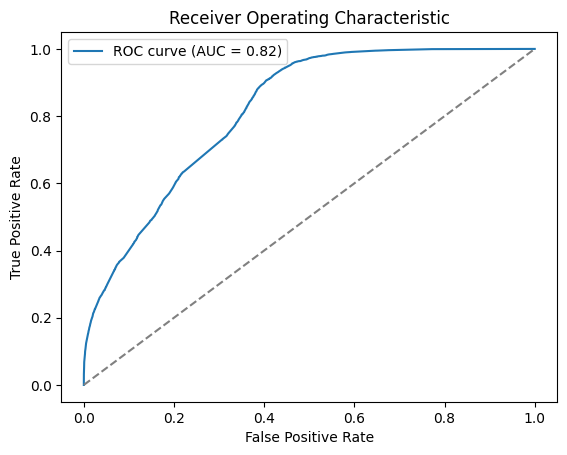

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_tests, probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
numeric_df = df_feat.select_dtypes(include=[np.number])
    if df_feat.isnull().values.any() or df_feat.isna().values.any() or np.isinf(numeric_df.values).any():
        print(f"Mã {ticker} có NaN hoặc inf")